In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import ensemble
from sklearn.model_selection import cross_val_score

from sklearn import tree

%matplotlib inline

# Import, inspect, and clean data

In [68]:
header = ['Sample code number', 'Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Class', ]
df = pd.read_csv('breast-cancer-wisconsin.csv', names=header)
df.head()

Sample code number  Clump Thickness  Uniformity of Cell Size  \
0             1000025                5                        1   
1             1002945                5                        4   
2             1015425                3                        1   
3             1016277                6                        8   
4             1017023                4                        1   

   Uniformity of Cell Shape  Marginal Adhesion  Single Epithelial Cell Size  \
0                         1                  1                            2   
1                         4                  5                            7   
2                         1                  1                            2   
3                         8                  1                            3   
4                         1                  3                            2   

  Bare Nuclei  Bland Chromatin  Normal Nucleoli  Mitoses  Class  
0           1                3                1        1      2  
1          10                3                2        1      2  
2           2                3                1        1      2  
3           4                3                7        1      2  
4           1                3                1        1      2

### Clean

In [69]:
# Convert Bare Nuclei to int
df['Bare Nuclei'].unique()
df = df[df['Bare Nuclei'] != '?'].dropna()
df['Bare Nuclei'] = df['Bare Nuclei'].apply(lambda a: int(a))

In [70]:
# Set indicator to binary O (none) and 1 (has cancer)
df.Class.isna().sum() # Check for NAs
df.Class = df.Class.apply(lambda n: 0 if n == 2 else 1)

In [125]:
def run_model(model_instance, X=None, y=None, df=None, outcome_col=None):
    X = X or df.drop(outcome_col, axis='columns')
    y = y or df[outcome_col]

    print(f'Class balance: {round(100*y.mean(), 1)}% ({y.sum()}) are 1')
    folds = 5
    cv_scores = cross_val_score(model_instance, X, y, cv=folds)
    print('Cross Val Scores:')
    print(f'Avg: {round(100*cv_scores.mean(), 2)} \nStd: {round(100*cv_scores.std(), 2)}')
    
    model_instance.fit(X, y)
    print('__DONE__')
    return model_instance, X, y

def get_forest_feature_importance(forest, X):
    importances = forest.feature_importances_
    indices = np.argsort(importances)[::-1]
    names = [X.columns[i] for i in indices]
    
    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", align="center")
    plt.xticks(range(X.shape[1]), names)
    plt.xlim([-1, X.shape[1]])
    for tick in plt.gca().get_xticklabels():
        tick.set_rotation(85)
    plt.show()

## Random Forest

In [98]:
rfc = ensemble.RandomForestClassifier(
    max_depth=3,
    n_estimators=100,
    random_state=42
)
rfc, X, y = run_model(rfc, df=df, outcome_col='Class')

Class balance: 35.0% (239) are 1
Cross Val Scores:
Avg: 96.78 
Std: 1.5
__DONE__


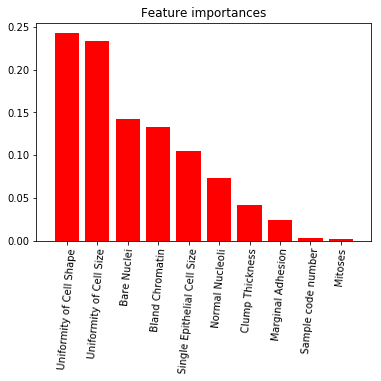

In [126]:
get_forest_feature_importance(rfc, X)

## A single decision tree has explanatory power, and performs nearly as good 

## (`93.9%` vs `96.8`)

Naturally, the decision tree *does* **overfit more than the RF**, with a standard deviation more than twice that of the RF, but still not too bad.

In [99]:
def visualize_tree(decision_tree, X, outcomes=['0', '1']):
    from IPython.display import Image
    import pydotplus
    import graphviz
    # Render our tree.
    dot_data = tree.export_graphviz(
        decision_tree, out_file=None,
        feature_names=X.columns,
        class_names=outcomes,
        filled=True
    )
    graph = pydotplus.graph_from_dot_data(dot_data)
    return Image(graph.create_png())

Class balance: 35.0% (239) are 1
Cross Val Scores:
Avg: 93.85 
Std: 2.29
__DONE__


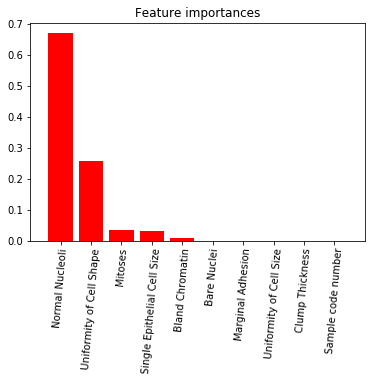

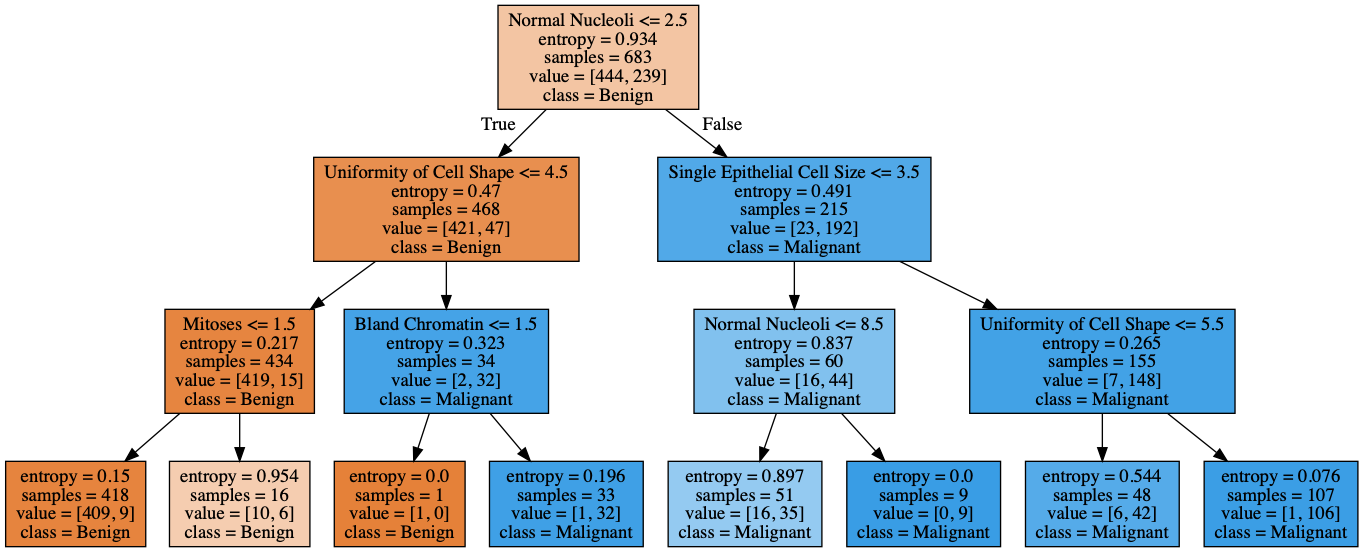

In [128]:
# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=3,
    random_state=42,
)
decision_tree, X, y = run_model(decision_tree, df=df, outcome_col='Class')
get_forest_feature_importance(decision_tree, X)
visualize_tree(decision_tree, X, outcomes=['Benign', 'Malignant'])

# Discussion
## Performance

Both perform quite well. The `3%` poorer performance by the tree seems a small cost to pay for its incredible explainability.


## Feature importance
### RF
The RF chose `Uniformity of Cell Shape` and `Uniformity of Cell Size` as the two most important features, with a generally **linear decrease in significance** from most to least significant. 

### Decision Tree
The single tree, in contrast, selects `Normal Nucleoli` and `Uniformity of Cell Shape` as *hugely* important, *assigning little or no importance to the remaining feagures*. This makes sense given the tree, which recieves nearly all of its predictive power from the root split (`Normal Nucleoli`), and the first left child split (`Uniformity of Cell Shape`). Notably, **the entire left side of the tree classifies as 'Malignent.'

From the image alone, we can easily read off:

### *"If `Normal Nucleoli` is less than 2.5, the cancer is unlikely to be malignent unless `Uniformity of Cell Shape` is greater than 4.5"*